In [ ]:
!git clone https://github.com/anm-ol/DreamLab
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p DreamLab/data/video
!mkdir -p DreamLab/data/mario
!mkdir -p DreamLab/weights
!cp drive/MyDrive/data/videos/mario_gameplay.mp4 DreamLab/data/video/mario_gameplay.mp4
%cd DreamLab

In [93]:
from src.data import *
extract_frames('data/video/mario_gameplay.mp4', 400, 1400, 2, 'data/mario', size=(256, 256))
split_data2('data/mario', test_split=0.2, num_frames=1)

Total frames in video: 69878


In [12]:
from src.data import videoDataset
from torch.utils.data import DataLoader
dataset = videoDataset('data/mario', 'data/train.txt', (256, 256))
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

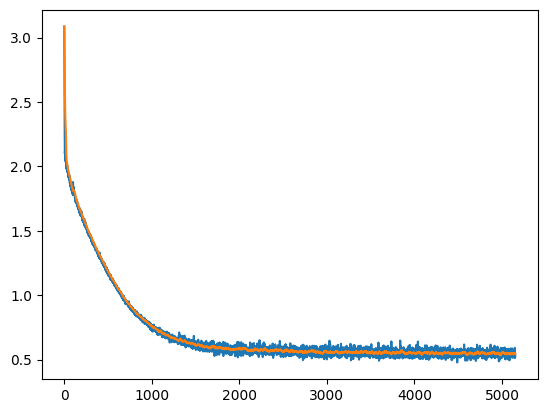

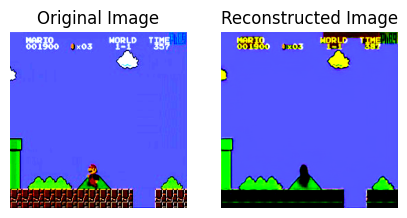

In [4]:
from src.autoencoder import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myvae = vae().to(device)
train(myvae, dataloader, dataset=dataset, lr=0.001, num_epochs=50)


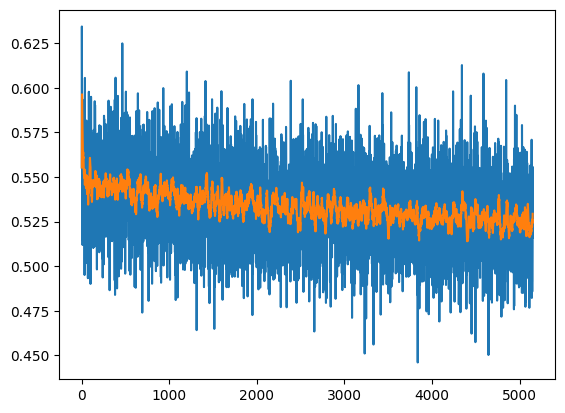

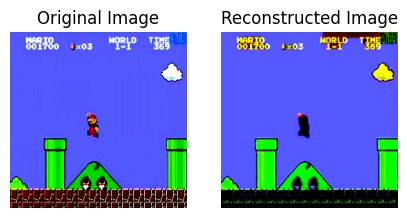

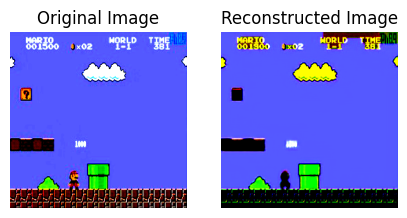

In [5]:
train(myvae, dataloader, lr=0.001, dataset=dataset, num_epochs=50)
sample_image(myvae, dataset, 0)

In [3]:
torch.save(myvae.state_dict(), 'weights/simplevae_weights.pth')
torch.save(dataset, 'weights/dataset.pth')


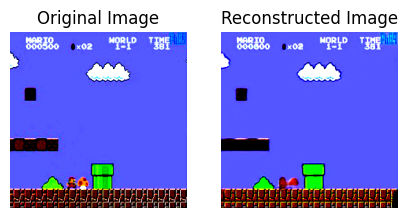

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from src.autoencoder import *
myvae = vae().to(device)
myvae.load_state_dict(torch.load('weights/simplevae_weights.pth'))
dataset = torch.load('weights/dataset.pth')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
sample_image(myvae, dataset, 0)

In [27]:
from src.DiT import *

def train_denoiser(dit_model, vae, dataloader, num_steps=10, lr=0.0001, num_epochs=10, scheduler='linear'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dit_model.train()
    vae.eval()
    if scheduler == 'linear':
        linear = LinearNoiseScheduler(num_steps, beta_start=0.0001, beta_end=0.02)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(dit_model.parameters(), lr=lr)
    alphas = get_schedule(num_steps)
    losses = []
    losses_mean = []
    for epoch in range(num_epochs + 1):
        for i, input in enumerate(dataloader):
            input = input[:, 0].to(device)
            with torch.no_grad():
                input = vae.encoder(input)
                input = (input - 2) / 3.5
                batch_Size = input.shape[0]
                original_noise = torch.randn_like(input).to(device)
                if scheduler == 'cosine':
                    t = torch.randint(0, num_steps-1, size=(batch_Size,))
                    alpha = torch.tensor(alphas[t])
                    alpha = alpha.reshape(-1, 1, 1, 1).to(device)
                    noised, original_noise = add_noise(input, alpha)
                    noised = noised.float().to(device)
                    original_noise = original_noise.to(device)
                elif scheduler == 'linear':
                    t = torch.randint(0, num_steps - 1, (batch_Size,))
                    noised = linear.add_noise(input, original_noise, t)
            optimizer.zero_grad()
            loss = criterion(dit_model(noised, t), original_noise)
            losses.append(loss.item())
            loss_mean = torch.tensor(losses[-40:]).mean()
            losses_mean.append(loss_mean)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch}, Loss: {loss_mean:.4f}')
        if epoch % 5 == 0:
            clear_output()
            plt.plot(losses)
            plt.plot(losses_mean)
            plt.show()

def diffusion_sampler(vae, dit_model, num_samples=1, num_steps=10, scheduler='linear'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vae.eval()
    dit_model.eval()
    img = dataset[0][0].unsqueeze(0).to(device)
    latent = vae.encoder(img).repeat(num_samples, 1, 1, 1)
    latent = torch.randn_like(latent)
    output = vae.decoder(latent)
    if scheduler=='cosine':
        alphas_cum = torch.tensor(get_schedule(num_steps)).to(device).float()
    elif scheduler=='linear':
        linear = LinearNoiseScheduler(num_steps, beta_start=0.0001, beta_end=0.02)
    plt.figure(figsize=(3, 3))
    plt.imshow(output[0].permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.show()
    time.sleep(0.1)
    with torch.no_grad():
        for t in torch.arange(num_steps-1, -1, -1):
            t = t.repeat(num_samples)
            eps =  dit_model(latent, t)
            if scheduler == 'cosine':
                #print(f'Step {t[0]}, alpha: {alphas_cum[t[0]]}')
                t = t.reshape(-1, 1, 1, 1)
                alpha_t = alphas_cum[t]/alphas_cum[t-1] if t[0] > 0 else alphas_cum[t]
                alpha_t = alpha_t.to(device)
                sigma_t = (1 - alpha_t) * (1 - alphas_cum[t-1]) / (1 - alphas_cum[t]).to(device)
                sigma_t = sigma_t ** 0.5
                latent = (latent - (eps * (1 - alpha_t)/torch.sqrt(1 - alphas_cum[t].to(device)))) / torch.sqrt(alpha_t) 
                t = t.view(-1)
            elif scheduler == 'linear':
                sigma_t = 0
                t = t.reshape(-1, 1, 1, 1)
                latent, _ = linear.sample_prev_timestep(latent, eps, t)
                t = t.view(-1)
                            
            if t[0] == 0:
                latent = latent
            else:   
                z = torch.randn_like(latent).to(device) 
                latent = latent + sigma_t * z
            output = vae.decoder(latent * 3.5 + 2)
            output = torch.clamp(output, 0, 1)
            if t[0] % (num_steps//10) == 0:
                print(f'Step {t[0]}')
                fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
                for i in range(num_samples):
                    axes[i].imshow(output[i].permute(1, 2, 0).cpu().numpy())
                    axes[i].axis('off')
                plt.show()
    return output

In [10]:
from src.utils import *
dit = DiT(num_dit_blocks=12, patch_size=2, dims=512).to(device)
count_parameters(dit)

67.620096M


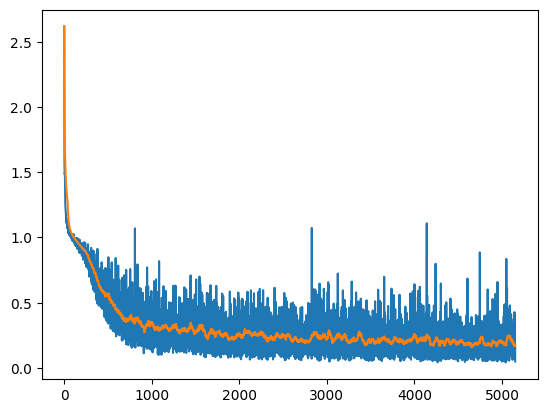

In [14]:
train_denoiser(dit, myvae, dataloader, num_steps=1000, lr=1e-5, num_epochs=50, scheduler='cosine')


In [3]:
dit, _= load_model_with_config('weights/dit_config.pth')
dit = dit.to(device)

In [40]:
config = {
    'num_dit_blocks': 8,
    'patch_size': 2,
    'dims': 1024,
    'scheduler': 'linear'
}
save_model_with_config(dit, 'weights/dit_config.pth', config, myvae)

In [33]:
dit.load_state_dict(torch.load('weights/dit8x_step1000patch2linear.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.014321859..2.4186513].


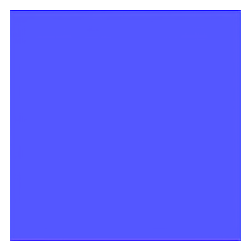

Step 900


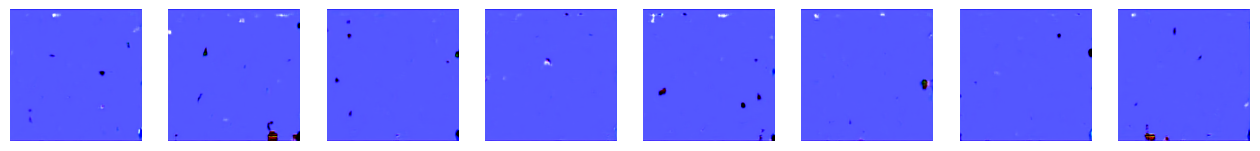

Step 800


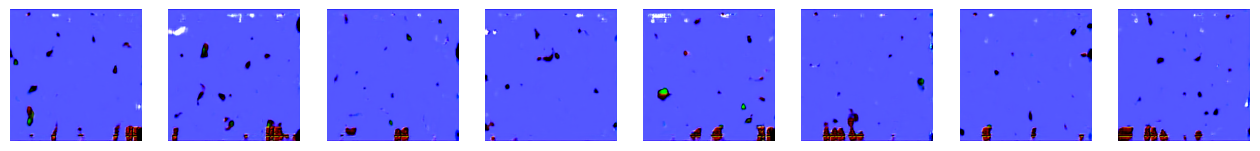

Step 700


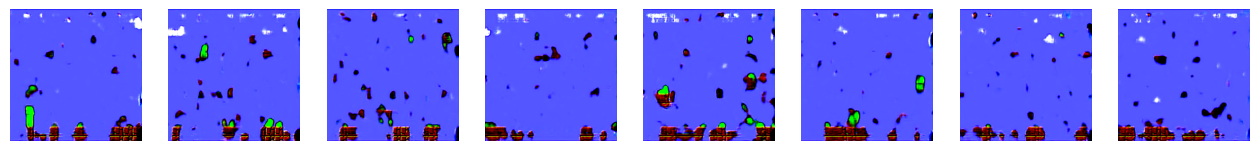

Step 600


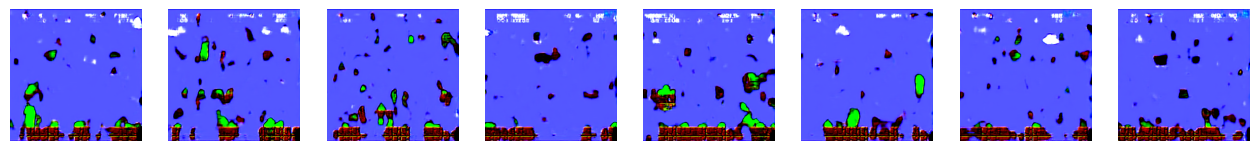

Step 500


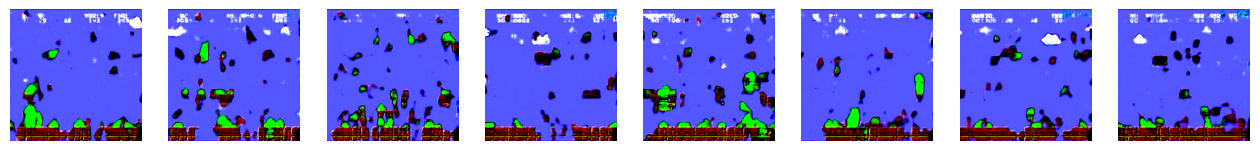

Step 400


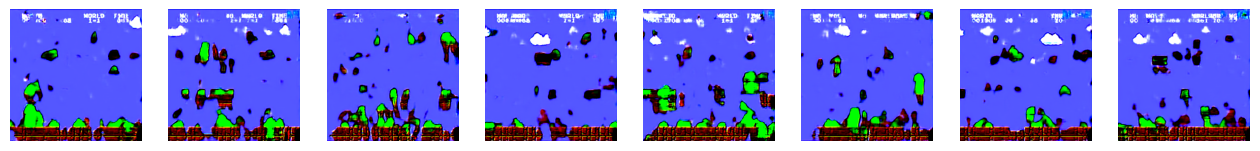

Step 300


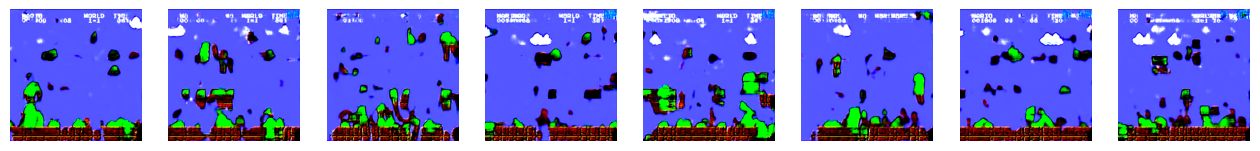

Step 200


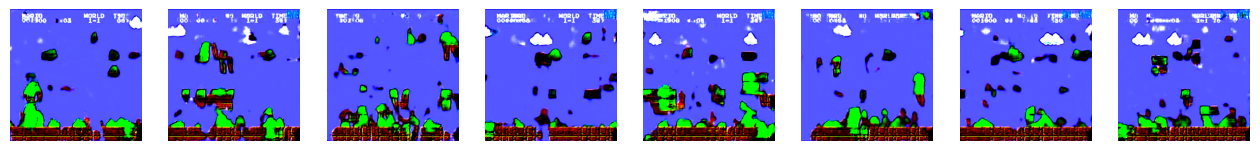

Step 100


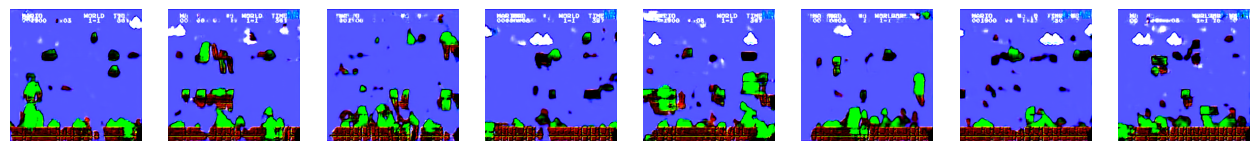

Step 0


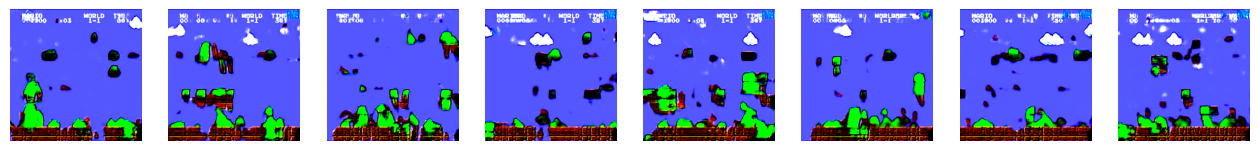

In [29]:
result = diffusion_sampler(myvae, dit, num_samples=8, num_steps=1000, scheduler='linear')